In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft
import os

In [9]:
from ImgProcess import *     # import all functions from ../Codes/ImgProcessing.py
from KSVD import *              # import all functions from ../Codes/KSVD.py

# 0. read the images

In [3]:
path = os.listdir('../Pictures/')
imgs_gray = []
# read all .png files in ../Pictures/ (i.e. the gray-scale images)
for file in [file for file in path if file.endswith('.png')]:
    imgs_gray.append(plt.imread('../Pictures/' + file))

In [4]:
path = os.listdir('../Pictures/McM/')

imgs_clear = []
for file in [file for file in path if 'noise' not in file and file.endswith('.tif')]:
    _img = plt.imread('../Pictures/McM/' + file)    # extract the color channels
    imgs_clear.append([_img[:,:,0], _img[:,:,1], _img[:,:,2]])

imgs_noise = []
for file in [file for file in path if 'noise' in file and file.endswith('.tif')]:
    _img = plt.imread('../Pictures/McM/' + file)    # extract the color channels
    imgs_noise.append([_img[:,:,0], _img[:,:,1], _img[:,:,2]])

# Task 1. 灰色图像的字典学习算法

使用 K-SVD 算法对灰度图像进行字典学习. 

In [12]:
# Divide the images into patches
img = imgs_gray[0]
size = 8
patches, locs, dcs = Img2patch(img, size, 2)

## K-SVD 算法

1. **初始化字典**: 

    选取 DCT（离散余弦变换）原子作为初始字典，字典的大小为 $n \times 2n$，其中 $n$ 为 patch 的大小; 为了实现稀疏表示，选取 $2n$ 个原子组成过完备字典，并进行归一化. 

2. **稀疏编码**: 对 patches 中的每条 patch，使用 OMP 算法进行稀疏编码.
    
3. **更新字典**：逐步更新字典中的原子（基向量）

   - **选取样本**：选取使用当前原子表示的样本. 
   - **更新原子**：对残差进行梯度下降，更新原子. 

4. **重复迭代**：重复步骤 2, 3，直到满足停止条件（达到最大迭代次数 / 字典不再发生显著变化）

### 稀疏编码: OMP 算法

设输入信号为 $y$，字典为 $D$，稀疏表示向量为 $x$. OMP 算法目标是找到最优的稀疏表示 $x$ s.t. $y = Dx$. OMP 算法的流程如下：

- **初始化**: 设 $x = 0$，$r = y$. 
- **迭代**：
   1. 选择最相关的原子: 找到字典 $D$ 中与残差 $r$ 最相关（内积最大）的基向量，假设是第 $k$ 个. 
   2. 更新: $x_k = x_k + d_k^T r$; $r = r - d_k^T r \cdot d_k$. 
   3. 检查条件：重复步骤 2, 3，检查 $x$ 稀疏度、残差大小是否满足精度要求，若有一项满足，则停止迭代. 

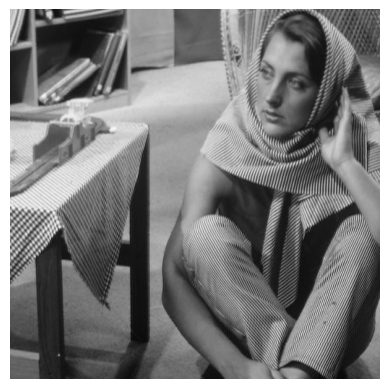

In [13]:
# Initialize the dictionary as the DCT basis
mD = fft.dct(np.eye(2 * size**2), norm='ortho')[: size**2]
patches, mD, _ = KSVD(patches, mD, 12)
img_learned = Img2patch(patches, locs, dcs, inv=True)
Showing(img_learned)

### 字典更新

从字典中选择原子 $d_k$，设利用此原子进行稀疏编码的样本为 $Y_k$

1. **选取字典中的原子**: 对于每一个字典中的原子（基向量），依次进行更新。
2. **选取相关样本**: 对于当前待更新的原子，找到使用该原子进行稀疏编码的样本。
3. **更新原子**: 通过梯度下降法优最小化残差，以更新当前选定的原子
4. **更新残差**: 
   - 对于每个使用当前更新原子进行稀疏表示的样本，根据新的原子和系数计算残差。

5. **重复迭代**：
   - 对所有字典中的原子重复上述步骤，直到满足停止条件（如达到最大迭代次数或字典变化不大）。

$$
\Phi(d) = 
$$